In [246]:
import pandas as pd          
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings # To ignore the warnings warnings.filterwarnings("ignore")

# Hypothesis
### 1.Traffic will increase as the years pass by 
### 2.Traffic will be high from May to October
### 3.Traffic on weekdays will be more
### 4.Traffic during the peak hours will be high

In [247]:
train=pd.read_csv("Train_SU63ISt.csv") 
test=pd.read_csv("Test_0qrQsBZ.csv")

In [248]:
train_original=train.copy() 
test_original=test.copy()

In [249]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [250]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [251]:
train.shape, test.shape

((18288, 3), (5112, 2))

# changing datatype of Datetime to datetime format and extracting features

In [252]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

# extracting the year, month, day and hour from the Datetime to validate our hypothesis

In [253]:
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

# extracting the day of week from Datetime
# Values of 5 and 6 represents that the days are weekend

In [254]:
train['day of week']=train['Datetime'].dt.dayofweek 
temp = train['Datetime']

In [255]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2

# looking at  the time series 

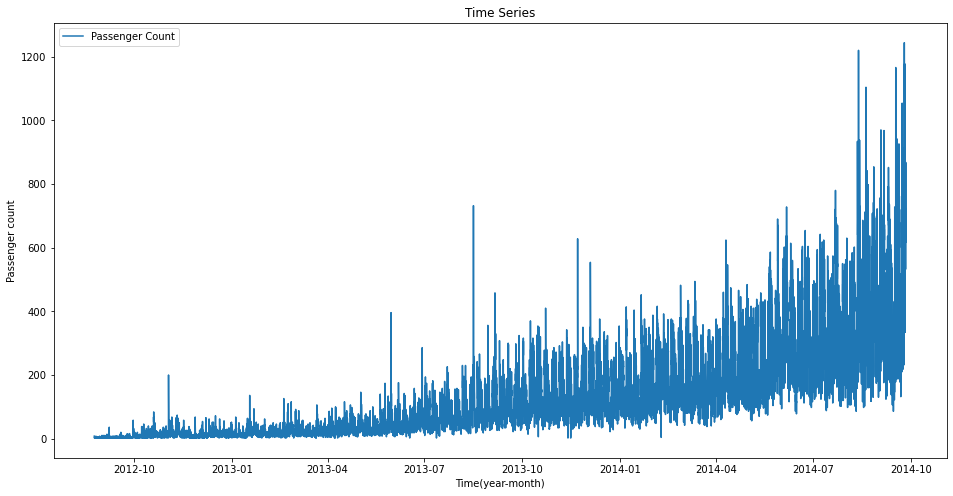

In [256]:
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

# verifying first hypothesis(traffic will increase as the years pass by)


<AxesSubplot:xlabel='year'>

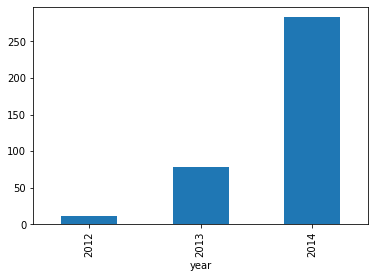

In [257]:
train.groupby('year')['Count'].mean().plot.bar()

# second hypothesis(traffic will increase from May to October)

<AxesSubplot:xlabel='month'>

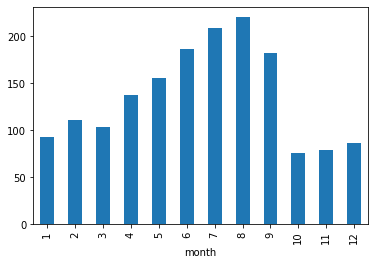

In [258]:
train.groupby('month')['Count'].mean().plot.bar()

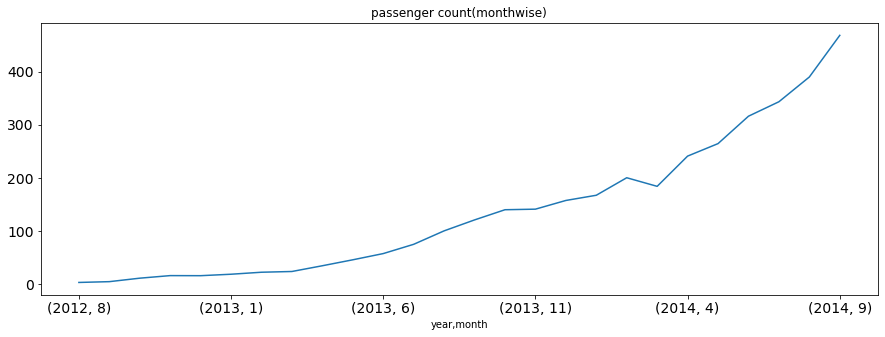

In [259]:
temp=train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize = (15,5),title='passenger count(monthwise)',fontsize = 14)
plt.show()

# third hypothesis(the traffic will be more on weekdays)

<AxesSubplot:xlabel='weekend'>

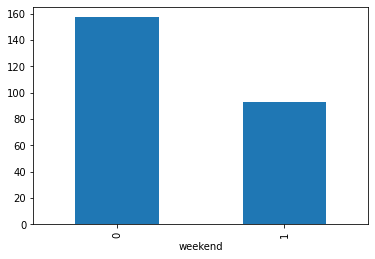

In [260]:
train.groupby('weekend')['Count'].mean().plot.bar()

# forth hypothesis(the traffic will be more during peak hour)

<AxesSubplot:xlabel='Hour'>

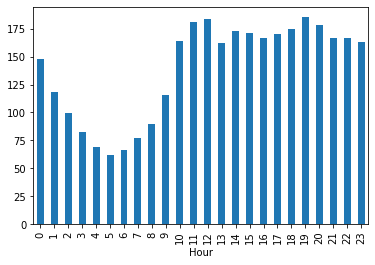

In [261]:
train.groupby('Hour')['Count'].mean().plot.bar()
#the peak traffic is at 7(19) PM and then we see a decreasing trend till 5 AM.
#After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.

<AxesSubplot:xlabel='day of week'>

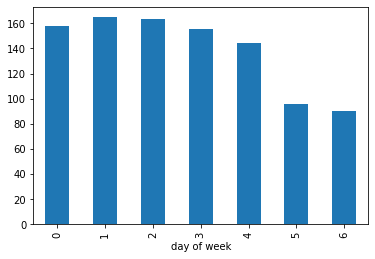

In [262]:
# looking at the day wise passenger count
# 0 is Monday(starting of week) and 6 is Sunday
train.groupby('day of week')['Count'].mean().plot.bar()

In [263]:
train=train.drop('ID',1) #dropping ID varaible
#for better visualization of hourly time series we will aggregate hourly time series to daily, weekly, and monthly 
#time series to reduce the noise and make it more stable 

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 

# Hourly time series 
hourly = train.resample('H').mean() 

# Converting to daily mean 
daily = train.resample('D').mean() 

# Converting to weekly mean 
weekly = train.resample('W').mean() 

# Converting to monthly mean 
monthly = train.resample('M').mean()


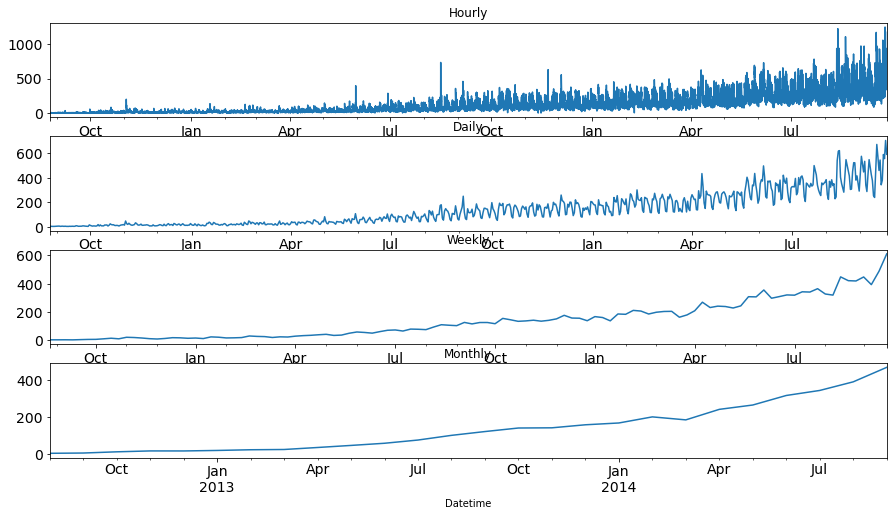

In [264]:
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 
plt.show()


In [265]:
#hence time series become more and more stable as we are aggregating it on hourly,daily, weekly and monthly basis.
#working on the daily time series as it is covinent for hourly prediction

test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean() 

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Converting to daily mean 
train = train.resample('D').mean()


# Validation Complete for hypothesis
## splitiing dataset into training and validation part(last 3 months taken for validation only)

In [266]:
Train=train.loc['2012-08-25':'2014-06-24']
valid=train.loc['2014-06-25':'2014-09-25'] #last 3 months taken for validation part
warnings.filterwarnings("ignore")

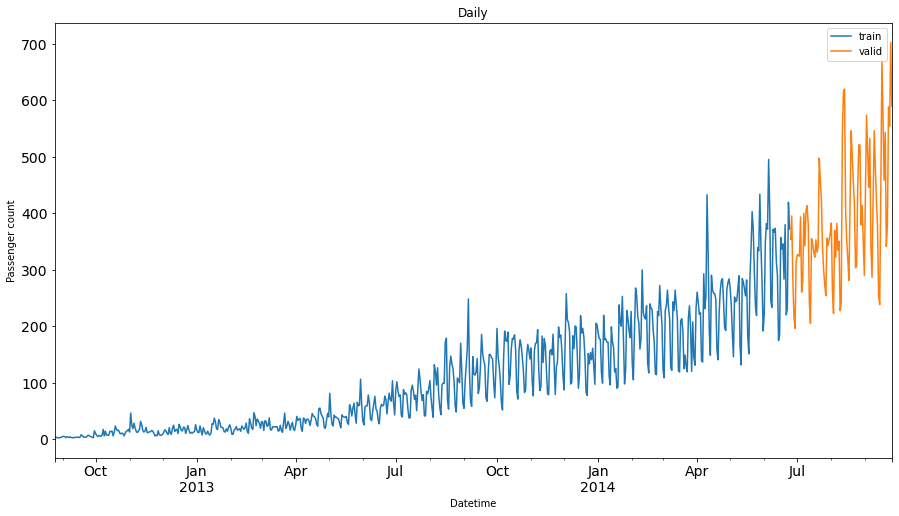

In [267]:
Train.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

# algorithm for our project
## 1.Construction of an SARIMA model
    1.1 Stationarize the series either by differencing or logging.
    1.2 Study the pattern of autocorrelation and partial autocorrelation to determine if lags of stationarized series or                lags of forecast errors should be included in forecasting equation.
    1.3 calculate ACF and PACF(tools for identifying SARIMA model).
    1.3 develop the forecasting equation.
## 2.fit the SARIMA model
## 3.make prediction with the fit model


# Construction of  an SARIMA model


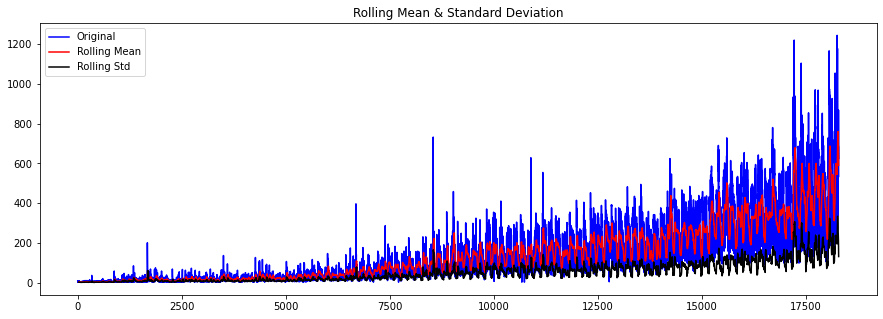

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [268]:
#dicky fuller test for finding stationary
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
        
    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()
        
    #Plot rolling statistics:
    plt.figure(figsize = (15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
  
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#calling the function
test_stationarity(train_original['Count'])

The statistics shows that the time series is stationary as Test Statistic < Critical valuebut we can see an increasing trend in the data.
So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

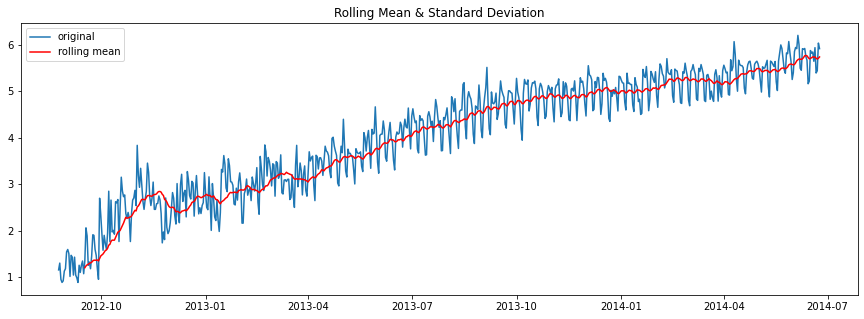

In [269]:
# Stationarize the series(removing Trend)

Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(24).mean() # taking the window size of 24 based on the fact that each day has 24 hours

plt.figure(figsize = (15,5))
plt.plot(Train_log,label = 'original') 
plt.plot(moving_avg,color = 'red',label = 'rolling mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

There is an increasing trend,so removing it in order to make our time series stationary.

In [270]:
train_log_moving_avg_diff = Train_log - moving_avg

In [271]:
#dropping first 23 values as we have taken average of 24 values(clearly seen in the graph)
train_log_moving_avg_diff.head(24)

Datetime
2012-08-25         NaN
2012-08-26         NaN
2012-08-27         NaN
2012-08-28         NaN
2012-08-29         NaN
2012-08-30         NaN
2012-08-31         NaN
2012-09-01         NaN
2012-09-02         NaN
2012-09-03         NaN
2012-09-04         NaN
2012-09-05         NaN
2012-09-06         NaN
2012-09-07         NaN
2012-09-08         NaN
2012-09-09         NaN
2012-09-10         NaN
2012-09-11         NaN
2012-09-12         NaN
2012-09-13         NaN
2012-09-14         NaN
2012-09-15         NaN
2012-09-16         NaN
2012-09-17    0.144489
Freq: D, Name: Count, dtype: float64

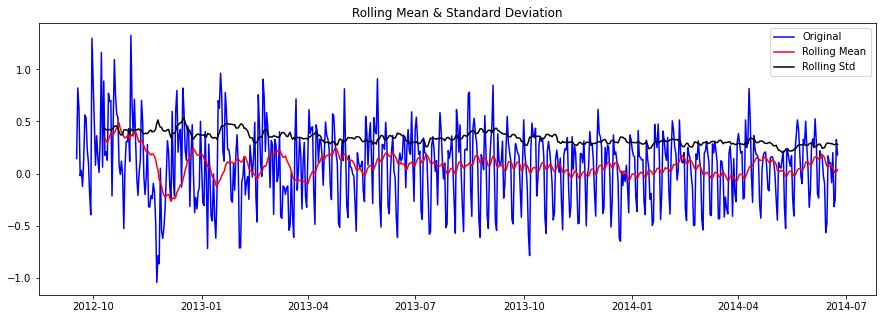

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [272]:
#dropping these NaN values and checking the plots to test stationarity.
test_stationarity(train_log_moving_avg_diff.dropna())

We can see that the Test Statistic is very smaller as compared to the Critical Value(even at 1% risk). So, we can be confident that the trend is almost removed

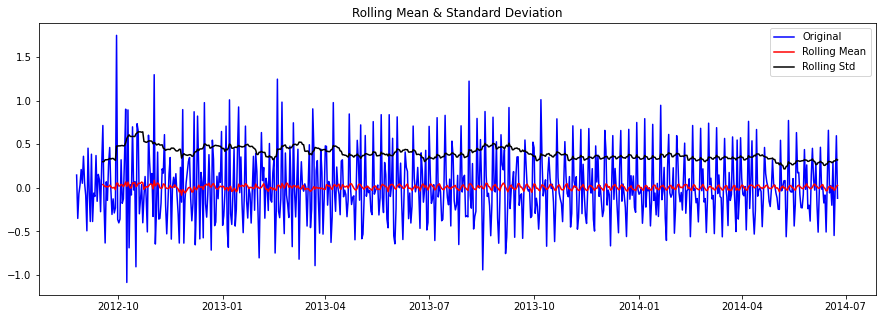

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [273]:
#even trying to make mean stationary
train_log_diff = Train_log - Train_log.shift(1) #differencing particular instant(t) with that of the previous instant(t-1).
test_stationarity(train_log_diff.dropna())

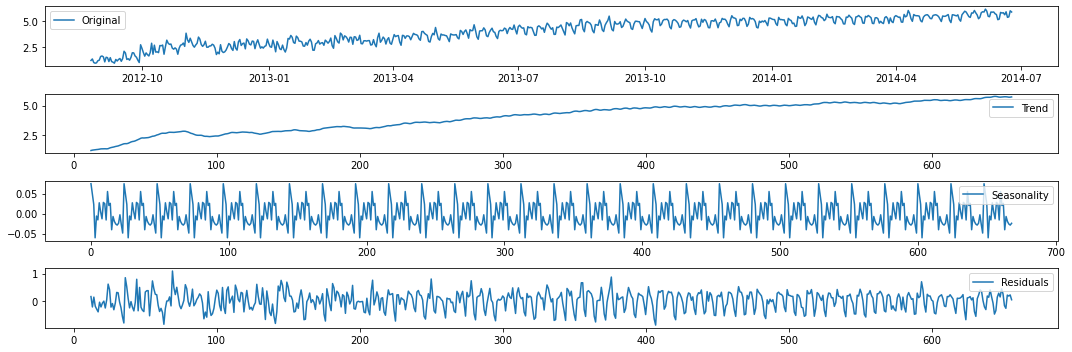

In [274]:
#removing seasonality

from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.figure(figsize = (15,5))
plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

We can see the trend, residuals and the seasonality clearly in the above graph. Seasonality shows a constant trend in counter.
Let’s check stationarity of residuals.

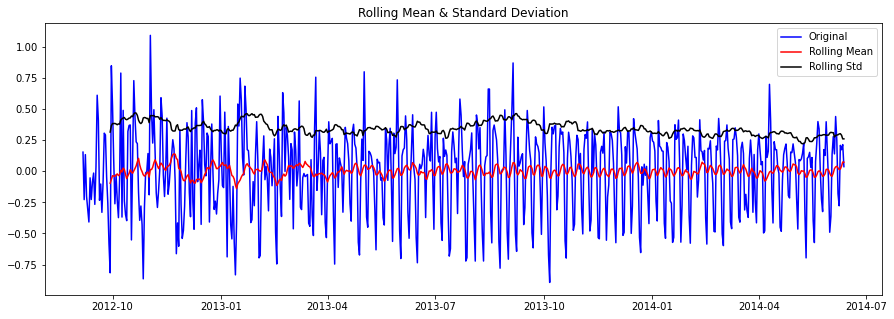

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [275]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

It can be interpreted from the results that the residuals are stationary.

Now we will forecast the time series using SARIMA model.

# Building SARIMA model (ARIMA(p,d,q)(P,D,Q)s)

finding each parameters

To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

In [276]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

ACF and PACF plot

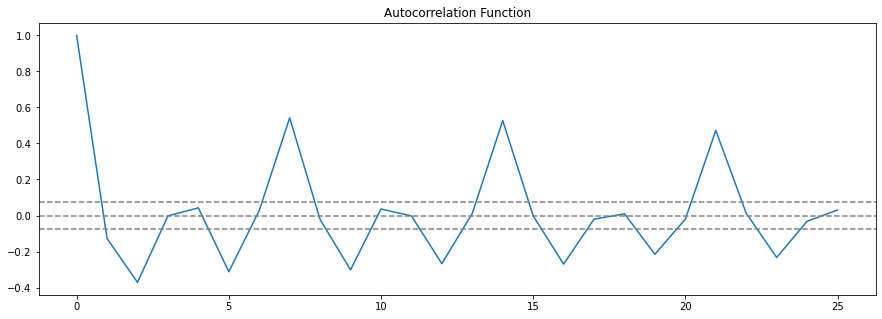

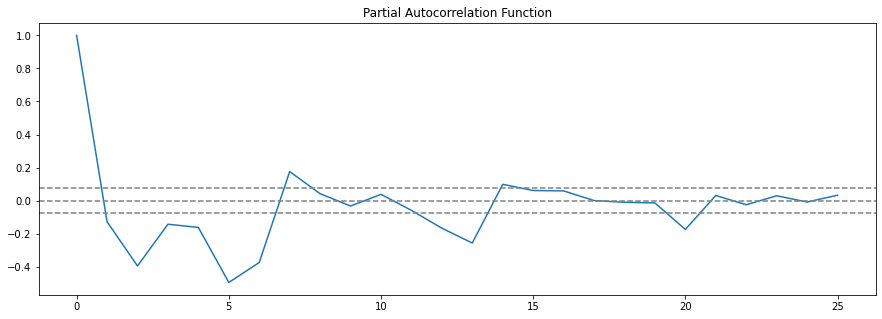

In [277]:
plt.figure(figsize = (15,5))
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function') 
plt.show() 

plt.figure(figsize = (15,5))
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function') 
plt.show()

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. from here in this case p=7.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. from here in this case q=3.

d - 1(already differenced above one time to remove trend)

-After putting the value p=7 and q=3, we got the rms value=96.18970374834375.

-Lower the rmse value(ranges from 67 to 70), better will be the data predicted.

-So, using different value of p and q to get better rmse value.

-Training the model with the most widely used parameters i.e.
(p,d,q)=(2,1,4)

(p,d,q)=(3,1,0)

(p,d,q)=(3,1,4)

-We got the following rmse values:

For (2,1,4)=69.55355944334258

For (3,1,0)=72.11428669929201
    
For (3,1,4)=68.70637065367659

Taking (3,1,4)

s - In our case the periodicity is 7 since it is daily time series and will repeat after every 7 days.

Q - from ACF chart we can clearly see repeat of the graph so Q = 1.

D - 1(differenced one time to remove seasonality)

P - from PACF there is no repeat of the graph so P = 0.

# Fit the SARIMA Model

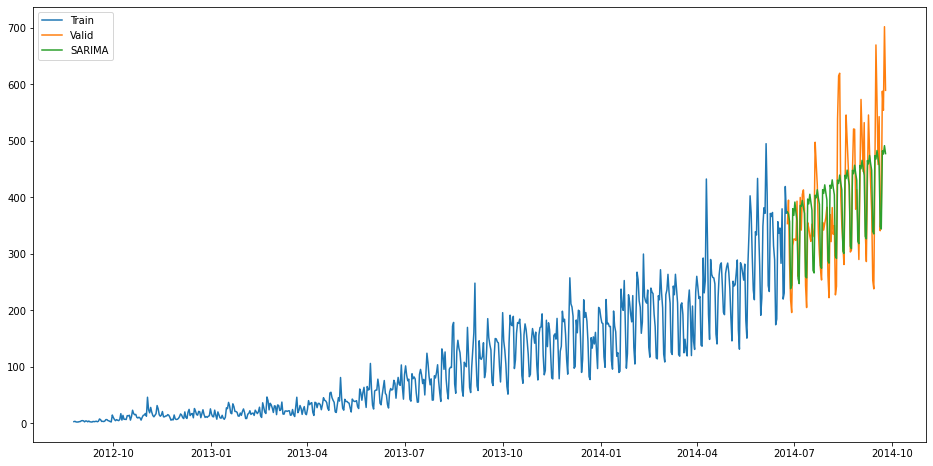

In [278]:

import statsmodels.api as sm
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(3,1,4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True)
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

# Make prediction with Fitted Model

In [279]:
#Let’s check the rmse value for the validation part.
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA)) 
print("Root mean squared error:",rms)

Root mean squared error: 68.70637065367659


Now we will forecast the time series for Test data which starts from 2014-9-26 and ends at 2015-4-26.

In [280]:
#loading the submission file.
submission=pd.read_csv("submission.csv")

#We only need ID and corresponding Count for the final submission.
#Let’s make prediction for the test dataset.
predict=fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)
#Let’s save these predictions in test file in a new column.
test['prediction']=predict

Note that these are the daily predictions and we need hourly predictions. 
To do so we will first calculate the ratio of passenger count for each hour of every day. Then we will find the average ratio of passenger count for every hour and we will get 24 ratios.Then to calculate the hourly predictions we will multiply the daily prediction with the hourly ratio.

In [281]:
# Calculating the hourly ratio of count
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 

# Grouping the hourly ratio 
temp=train_original.groupby(['Hour'])['ratio'].sum() 

# Groupby to csv format 
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv') 

temp2=pd.read_csv("GROUPby.csv") 
temp2=temp2.drop('Hour.1',1) 

# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month','Hour_x','Hour_y'], axis=1) 

# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left') 

# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24 


In [282]:
#drop all variables other than ID and Count
prediction['ID']=prediction['ID_y']
submission=prediction.drop(['ID_x', 'day', 'ID_y','prediction','Hour', 'ratio'],axis=1)

In [283]:
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Datetime','Count']).to_csv('SARIMAX.csv')


In [284]:
#observing the graph
Sarima=pd.read_csv("SARIMAX.csv") 
Sarima['Datetime'] = pd.to_datetime(Sarima.Datetime,format='%Y-%m-%d %H:%M:%S') 

test = pd.read_csv("Test_0qrQsBZ.csv")

test['Count'] = Sarima.Count
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
#checking to see if count column is added on the test file or not

print(Sarima.head(5))
print(Sarima.dtypes)

   Unnamed: 0     ID            Datetime       Count
0           0  18288 2014-09-26 00:00:00  494.508436
1           1  18289 2014-09-26 01:00:00  394.643604
2           2  18290 2014-09-26 02:00:00  333.990042
3           3  18291 2014-09-26 03:00:00  275.964039
4           4  18292 2014-09-26 04:00:00  232.279766
Unnamed: 0             int64
ID                     int64
Datetime      datetime64[ns]
Count                float64
dtype: object


# finally prediction combined

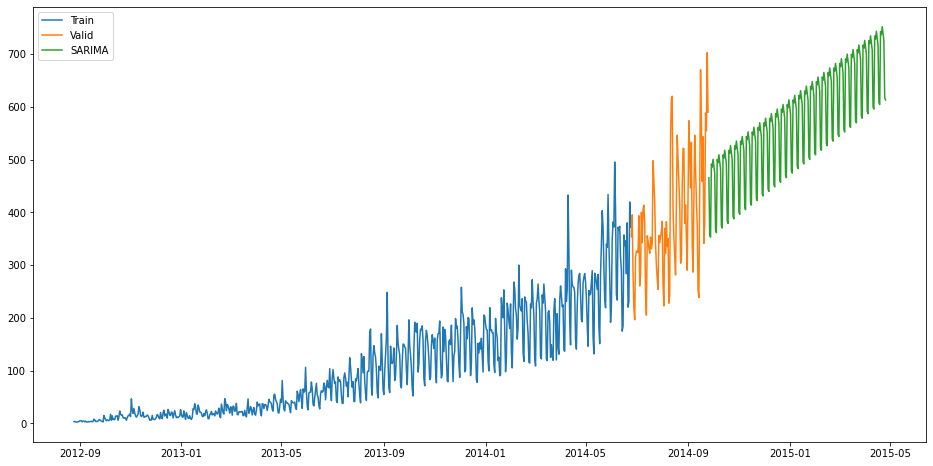

In [285]:

plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(predict, label='SARIMA') 
plt.legend(loc='best') 
plt.show()

# observing the time series then

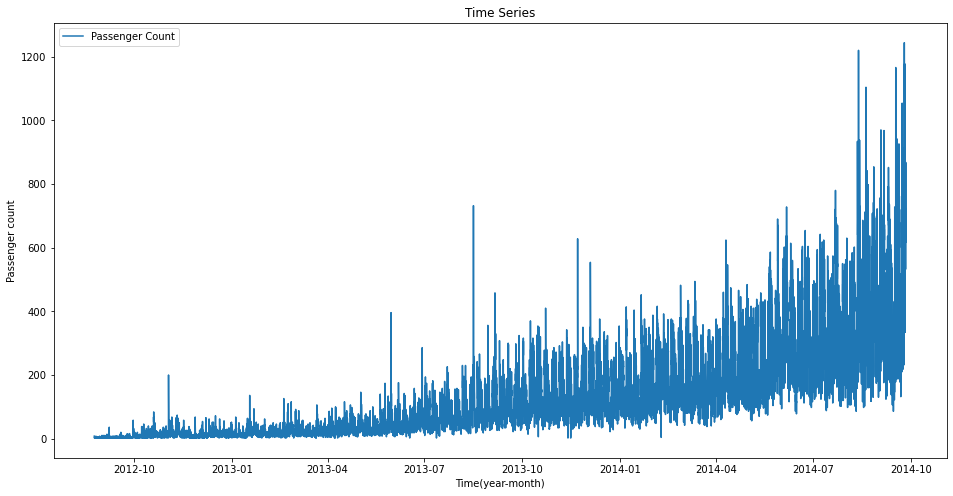

In [286]:
train=pd.read_csv("Train_SU63ISt.csv") 
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

# finally our predicted time series

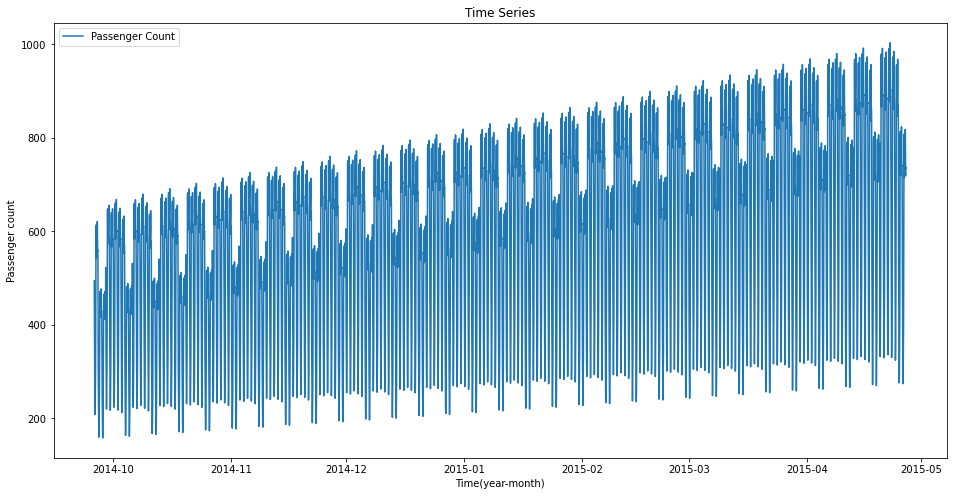

In [287]:
Sarima=pd.read_csv("SARIMAX.csv") 
Sarima['Datetime'] = pd.to_datetime(Sarima.Datetime,format='%Y-%m-%d %H:%M:%S') 
Sarima.index = Sarima['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df=Sarima.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')